In [10]:
import torch
from torchvision import datasets
import torchvision.transforms as transforms
import numpy as np
import os
import matplotlib.pyplot as plt


In [11]:
gpu_train = torch.cuda.is_available()
print(f"GPU is activated: {gpu_train}")

GPU is activated: True


In [12]:
num_workers = 4
batch_size = 500
val_size = 0.20
path = 'food-101/images'

transform = transforms.Compose([
    transforms.Resize(100),
    transforms.RandomCrop(90),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

dataset = datasets.ImageFolder(root = path, transform = transform)

train_size = int(len(dataset) * 0.7)
test_size = int(len(dataset) * 0.15)
valid_size = len(dataset) - train_size - test_size
train_dataset, test_dataset, valid_dataset = torch.utils.data.random_split(dataset, [train_size, test_size, valid_size])

classes = []
for root, dirs, files in os.walk(f"./{path}"):
   classes.append(dirs)
classes = classes[0]

print(f"Train Size: {train_size} ({100 * train_size/len(dataset)}%)")
print(f"Test Size: {test_size} ({100 * test_size/len(dataset)}%)")
print(f"Validation Size: {valid_size} ({100 * valid_size/len(dataset)}%)")
print(f"Number of Classes: {len(classes)}")
print(f"Total Size: {len(dataset)}")

Train Size: 70700 (70.0%)
Test Size: 15150 (15.0%)
Validation Size: 15150 (15.0%)
Number of Classes: 101
Total Size: 101000


Create Trainloaders

In [13]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, num_workers=num_workers)

Show Sample Images

tensor([ 66,   3,  99,  99,  32,  34,  63,  54,  10,  83,  85,  32,  75,  63,
         15,  19,   5,  32,  43,  86,  14,  28,  20,  39,  60,  92,  20,  21,
         71,  52, 100,  95,  34,  22,  98,  80,  72,  13,  95,  22,  95,  64,
         56,   7,   4,  44,   0,  77,  59,  91,  38,  92,  71,  92,  10,  94,
         39,   9,  21,   8,  20,  46,  38,  24,  88,  24,  21,  69,  70,  66,
         83,   2,  56,  44,   7,  70,   3,  39,  85,  56,  55,  56,  55,  81,
          3,  31,  10,   0,   4,  29, 100,  20,  26,  71,   3,  86,  53,  49,
         71,  70,  35,  33,  78,  60,  70,  48,  36,  60,  55,   4,  98,  82,
         53,   1,   3,  94,  86,  86,  76,  54,   0,  95,  87,  61,  46,  51,
         80,  41,  42,  19,  80,  27,  99,   0,  62,  55,  31,  33,  10,  69,
         70,  40,  14,  40,  35,   7,  11,  88,  74,  81,  42,  70,  82,  14,
         18,  30,  23,  98,  92,   3,  79,  96,  66,  72,  20,  93,  11,  35,
         78,  42,  80,  27,  21,  70,  13,  28,  25,  48,  50,  

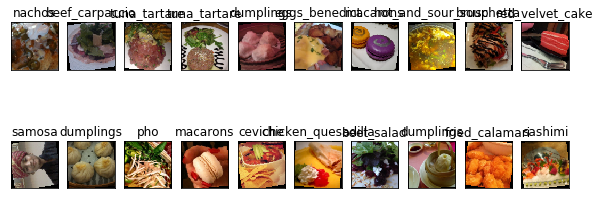

In [14]:
def imshow(img):
    img = img / 2 + 0.5 
    plt.imshow(np.transpose(img, (1, 2, 0)))

dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy()

print(labels)
fig = plt.figure(figsize=(10, 4))

for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(classes[labels[idx]])
    

In [15]:
import torch.nn as nn
import torch.nn.functional as F

In [16]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv4 = nn.Conv2d(64, 128, 3, padding=1)
        
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(3200, 500)
        self.fc2 = nn.Linear(500, 101)
        self.dropout = nn.Dropout(0.25)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x)))

        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

model = Net()
print(model)

if gpu_train:
    model.cuda()

Net(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=3200, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=101, bias=True)
  (dropout): Dropout(p=0.25, inplace=False)
)


In [17]:
import torch.optim as optim

# specify loss function (categorical cross-entropy)
criterion = nn.CrossEntropyLoss()

# specify optimizer
optimizer = optim.SGD(model.parameters(), lr=0.01)

In [18]:
# number of epochs to train the model
n_epochs = 30

valid_loss_min = np.Inf # track change in validation loss

for epoch in range(1, n_epochs+1):

    # keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0
    
    ###################
    # train the model #
    ###################
    model.train()
    for data, target in train_loader:
        # move tensors to GPU if CUDA is available
        if gpu_train:
            data = data.cuda()
            target = target.cuda()
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update training loss
        train_loss += loss.item()*data.size(0)
        
    ######################    
    # validate the model #
    ######################
    model.eval()
    for data, target in valid_loader:
        # move tensors to GPU if CUDA is available
        if gpu_train:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # update average validation loss 
        valid_loss += loss.item()*data.size(0)
    
    # calculate average losses
    train_loss = train_loss/len(train_loader.sampler)
    valid_loss = valid_loss/len(valid_loader.sampler)
        
    # print training/validation statistics 
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, train_loss, valid_loss))
    
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'fc101_model.pt')
        valid_loss_min = valid_loss

KeyboardInterrupt: 

In [0]:
model.load_state_dict(torch.load('fc101_model.pt'))

In [0]:
# track test loss
test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

model.eval()
# iterate over test data
for batch_idx, (data, target) in enumerate(test_loader):
    # move tensors to GPU if CUDA is available
    if train_on_gpu:
        data, target = data.cuda(), target.cuda()
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data)
    # calculate the batch loss
    loss = criterion(output, target)
    # update test loss 
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)    
    # compare predictions to true label
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
    # calculate test accuracy for each object class
    for i in range(batch_size):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# average test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(2):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[0][i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

In [0]:
import torch.nn as nn
import torch.nn.functional as F